In [113]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


True

In [112]:
run = wandb.init(project="convolutional-nn", id="wider-conv-layers-3-image-generator-earlystopping-lr-scheduler-linear-reduceLR")

In [114]:
EPOCHS = config['default'].getint('epochs')
IMAGE_SIZE = config['default'].getint('image_size')
BATCH_SIZE = config['default'].getint('batch_size')
SEED = config['default'].getint('seed')
START_LR = config['default'].getfloat('start_lr')
MAX_LR = config['default'].getfloat('max_lr')
STEPS_PER_EPOCH = config['default'].getint('steps_per_epoch')
ANNEAL_STRATEGY = config['default']['strategy']

wandb.config.update({'epochs': EPOCHS, 
                     'image_size': IMAGE_SIZE, 
                     'batch_size': BATCH_SIZE,
                     'start_lr': START_LR,
                     'max_lr': MAX_LR, 
                     'strategy': ANNEAL_STRATEGY})

In [115]:
data_path = 'Data/original'

class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
print("Number of Classes:", num_classes)

class_sizes = []
for name in class_names:
    class_size = len(os.listdir(data_path + "/" + name))
    class_sizes.append(class_size)

print("Class Distribution:\n", dict(zip(class_names, class_sizes)))

Number of Classes: 10
Class Distribution:
 {'butterfly': 2112, 'cat': 1668, 'chicken': 3098, 'cow': 1866, 'dog': 4863, 'elephant': 1446, 'horse': 2623, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


In [173]:
distribution = dict(zip(class_names, class_sizes))
distributionDf = pd.DataFrame.from_dict(distribution.items())
distributionDf.columns = ['Animal', 'Count']
distributionDf = distributionDf.reset_index()
distributionDf

,index,Animal,Count
0,0,butterfly,2112
1,1,cat,1668
2,2,chicken,3098
3,3,cow,1866
4,4,dog,4863
5,5,elephant,1446
6,6,horse,2623
7,7,sheep,1820
8,8,spider,4821
9,9,squirrel,1862


<AxesSubplot:title={'center':'Animal class distribution'}, ylabel='Animal'>

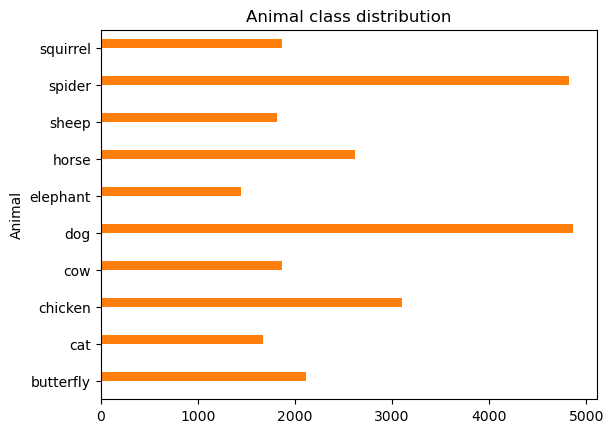

In [176]:
distributionDf.plot.barh(x = 'Animal', title='Animal class distribution', legend = False)

In [116]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/original',
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/original',
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


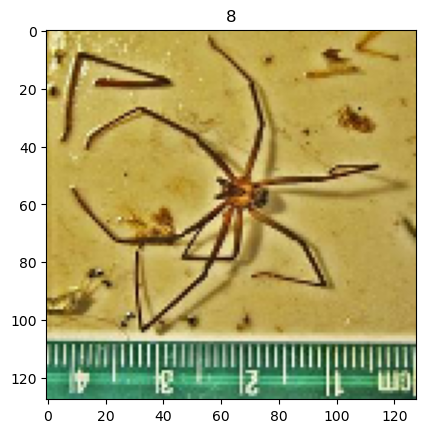

In [117]:
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(labels[0].numpy())
    break

In [118]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [119]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [120]:
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
                  'Data/original',
                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  subset='training',
                  class_mode='binary')

val_generator = train_datagen.flow_from_directory(
                  'Data/original',
                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  subset='validation',
                  class_mode='binary')   

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [121]:
def schedule(epoch):
    cycle = 0
    if epoch < (EPOCHS // 2):
        cycle = 1 + (epoch * STEPS_PER_EPOCH) // (EPOCHS // 2)
        factor = float(cycle * MAX_LR) / float(EPOCHS)
    else:
        cycle = 1 + ((EPOCHS - epoch) * STEPS_PER_EPOCH) // (EPOCHS // 2)
        factor = float(cycle * MAX_LR) / float(EPOCHS)
        factor = MAX_LR - factor

    if ANNEAL_STRATEGY == 'cos':
        lr = factor * (1 + tf.math.cos(tf.constant(np.pi) * (epoch % (EPOCHS // 2)) / (EPOCHS // 2))) / 2
    elif ANNEAL_STRATEGY == 'linear':
        lr = factor * (EPOCHS - epoch) / EPOCHS
    else:
        raise ValueError('Invalid anneal strategy')

    return lr

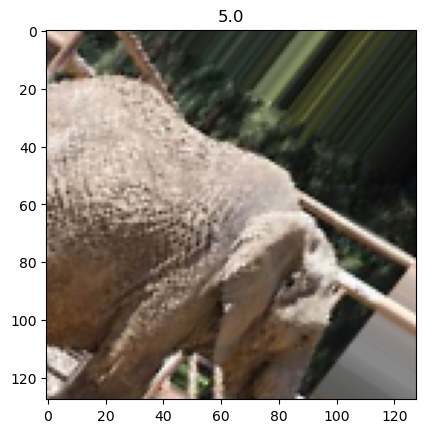

In [122]:
for images, labels in iter(train_generator):
    plt.imshow(images[0])
    plt.title(labels[0])
    break

In [123]:
class WandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)

In [125]:
""" with tf.device('/cpu:0'):
  augment = tf.keras.Sequential([
      layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2)
  ]) """

model = tf.keras.Sequential([
    #augment,

    layers.Conv2D(32, 3, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
#lr_scheduler = LearningRateScheduler(schedule=schedule, verbose=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.0001)

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)
]

model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 128)     

In [126]:
callbacks = [WandbCallback(), 
             EarlyStopping(monitor='val_sparse_categorical_accuracy', patience = 3, restore_best_weights=True), 
             ModelCheckpoint("model_checkpoint.h5", save_best_only=True), 
             reduce_lr]

In [127]:
model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10


2023-04-05 22:02:07.066294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - ETA: 0s - loss: 1.9617 - sparse_categorical_accuracy: 0.3062 - sparse_categorical_crossentropy: 1.9617

2023-04-05 22:03:20.172442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - 91s 138ms/step - loss: 1.9617 - sparse_categorical_accuracy: 0.3062 - sparse_categorical_crossentropy: 1.9617 - val_loss: 1.7103 - val_sparse_categorical_accuracy: 0.4140 - val_sparse_categorical_crossentropy: 1.7103 - lr: 0.0010
Epoch 2/10
655/655 [==============================] - 97s 147ms/step - loss: 1.6864 - sparse_categorical_accuracy: 0.4160 - sparse_categorical_crossentropy: 1.6864 - val_loss: 1.6401 - val_sparse_categorical_accuracy: 0.4302 - val_sparse_categorical_crossentropy: 1.6401 - lr: 0.0010
Epoch 3/10
655/655 [==============================] - 98s 150ms/step - loss: 1.5341 - sparse_categorical_accuracy: 0.4685 - sparse_categorical_crossentropy: 1.5341 - val_loss: 1.4430 - val_sparse_categorical_accuracy: 0.5038 - val_sparse_categorical_crossentropy: 1.4430 - lr: 0.0010
Epoch 4/10
655/655 [==============================] - 101s 154ms/step - loss: 1.4347 - sparse_categorical_accuracy: 0.5009 - sparse_categorical_crossentropy: 1

In [128]:
pd.DataFrame(model.history.history)

,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,val_loss,val_sparse_categorical_accuracy,val_sparse_categorical_crossentropy,lr
0,1.961688,0.306201,1.961688,1.710274,0.413991,1.710274,0.001
1,1.686367,0.416002,1.686367,1.640066,0.430237,1.640066,0.001
2,1.534123,0.468516,1.534123,1.443050,0.503823,1.443050,0.001
3,1.434706,0.500931,1.434706,1.385080,0.525420,1.385080,0.001
4,1.337806,0.537834,1.337806,1.309854,0.546254,1.309854,0.001
5,1.287431,0.553206,1.287431,1.298943,0.545872,1.298943,0.001
6,1.249961,0.566716,1.249961,1.284716,0.562118,1.284716,0.001
7,1.202525,0.585096,1.202525,1.181484,0.596139,1.181484,0.001
8,1.164896,0.598845,1.164896,1.131927,0.610474,1.131927,0.001
9,1.142256,0.606626,1.142256,1.157093,0.606078,1.157093,0.001


In [129]:
model.evaluate(val_generator)

164/164 [==============================] - 17s 101ms/step - loss: 1.1523 - sparse_categorical_accuracy: 0.6026 - sparse_categorical_crossentropy: 1.1523


[1.1522785425186157, 0.6026376485824585, 1.1522785425186157]

In [130]:
tf.keras.models.save_model(model, "model/larger-conv-layers-3-image-generator-lr-scheduler-linear-reduceLR.pth")
wandb.save('runs/pima_run_2023-04-05-larger-conv-layers-3-image-generator-earlystopping-lr-scheduler-linear-reduceLR')
wandb.finish()

INFO:tensorflow:Assets written to: model/larger-conv-layers-3-image-generator-lr-scheduler-linear-reduceLR.pth/assets


INFO:tensorflow:Assets written to: model/larger-conv-layers-3-image-generator-lr-scheduler-linear-reduceLR.pth/assets


loss,█▆▄▃▃▂▂▂▁▁
sparse_categorical_accuracy,▁▄▅▆▆▇▇▇██
sparse_categorical_crossentropy,█▆▄▃▃▂▂▂▁▁
val_loss,█▇▅▄▃▃▃▂▁▁
val_sparse_categorical_accuracy,▁▂▄▅▆▆▆▇██
val_sparse_categorical_crossentropy,█▇▅▄▃▃▃▂▁▁
loss,1.14226
sparse_categorical_accuracy,0.60663
sparse_categorical_crossentropy,1.14226
val_loss,1.15709
val_sparse_categorical_accuracy,0.60608
